In [1]:
# installs
!pip install tf_keras_vis &> /dev/null
!pip install scikit-plot &> /dev/null

In [2]:
# imports
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib import cm
import pandas as pd
import numpy as np
import seaborn as sns
import glob
import itertools
import random
from sklearn.model_selection import train_test_split
import keras.backend as K
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.utils import normalize
from sklearn.metrics import accuracy_score, classification_report
from scikitplot.metrics import plot_confusion_matrix

In [3]:
# setting seed for reproducability
seed = 1
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

- setting seeds for reproducability of the code

> **Task1: Load the images and their corresponding labels in your train variables : Train_X and Train_y.**


In [4]:
# downloading the dataset and unzipping
!gdown --id 1B8IK1C3xBs6Z-PV6AoINxWOzNV23C5IS
!unzip /content/FER.zip &> /dev/null
!rm -rf /content/FER.zip &> /dev/null
!rm -rf __MACOSX &> /dev/null

# loading the images and corresponding labels into variables, Train_X, Train_y, Test_X
happy_data_path = '/content/FER/train/happy'
neutral_data_path = '/content/FER/train/neutral'
test_data_path = '/content/FER/test/test_data.npy'

happy_paths = glob.glob(happy_data_path + '/**/*.jpg', recursive=True)
neutral_paths = glob.glob(neutral_data_path + '/**/*.jpg', recursive=True)

DATA_SIZE = len(happy_paths) + len(neutral_paths)
IMAGE_HEIGHT = 48
IMAGE_WIDTH = 48
NUM_CHANNELS = 1
NUM_CLASSES = 2
INPUT_SHAPE = (IMAGE_HEIGHT, IMAGE_WIDTH, NUM_CHANNELS)
print("Length of dataset: ", DATA_SIZE)

X = np.empty(shape=(DATA_SIZE, IMAGE_HEIGHT, IMAGE_WIDTH, NUM_CHANNELS))
y = np.empty(shape=(DATA_SIZE, NUM_CLASSES))

happy_zero = np.zeros(shape=(NUM_CLASSES))
happy_zero[0] = 1

neutral_one = np.zeros(shape=(NUM_CLASSES))
neutral_one[1] = 1

idx = 0
for path in happy_paths:
  img = tf.keras.preprocessing.image.load_img(path, color_mode='grayscale')
  arr = tf.keras.preprocessing.image.img_to_array(img)
  X[idx] = arr
  y[idx] = happy_zero
  idx+=1

for path in neutral_paths:
  img = tf.keras.preprocessing.image.load_img(path, color_mode='grayscale')
  arr = tf.keras.preprocessing.image.img_to_array(img)
  X[idx] = arr
  y[idx] = neutral_one
  idx+=1

Test_X = np.load(test_data_path)
TEST_DATA_SIZE = len(Test_X)

Train_X, Val_X, Train_y, Val_y = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=seed)
TRAIN_DATA_SIZE = len(Train_X)
VAL_DATA_SIZE = len(Val_X)
print("Train X shape:", Train_X.shape)
print("Train y shape:", Train_y.shape)
print("Val X shape:", Val_X.shape)
print("Val y shape:", Val_y.shape)
print("Test X shape:", Test_X.shape)

Downloading...
From: https://drive.google.com/uc?id=1B8IK1C3xBs6Z-PV6AoINxWOzNV23C5IS
To: /content/FER.zip
21.8MB [00:00, 52.6MB/s]
Length of dataset:  12179
Train X shape: (8525, 48, 48, 1)
Train y shape: (8525, 2)
Val X shape: (3654, 48, 48, 1)
Val y shape: (3654, 2)
Test X shape: (200, 48, 48, 1)


- preprocessing the data and getting four variables Train_X, Train_y, Val_X, Val_y
- loading the images from both the directories in grayscale format
- encoding the labels corresponding to the images from both the directories into one hot vector form
- there are total of 12179 images belonging to two classes happy and neutral facial expressions
- happy facial expression corresponds to one hot vector [1. 0.]
- neutral facial expression corresponds to one hot vector [0. 1.]
- splitting the loaded dataset into train and validation in the ration of 7:3

3917
[1. 0.]


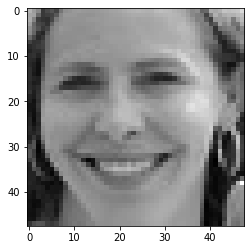

In [76]:
# random Train dataset observatory
num = np.random.randint(0, TRAIN_DATA_SIZE)
train_img = tf.keras.preprocessing.image.array_to_img(Train_X[num])
plt.imshow(train_img, cmap='gray')
print(Train_y[num])

- Randomly observing images from train dataset
- plotting the grayscale images using `matplotlib.pyplot`'s `imshow`

> **Task2: Build a CNN for binary classification using basic functions (like Convolution, Pooling, Batch Nor-malization, FNNs, etc.).**

In [39]:
def generate_model(input_shape, flatten=True, global_average_pooling=False, name='model'):
  # input
  input = tf.keras.Input(shape=input_shape, name='input')
  # feature extractor
  # block1
  MM = tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), strides=(1, 1), padding="same", name='conv1')(input)
  MM = tf.keras.layers.BatchNormalization(name='norm1')(MM)
  MM = tf.keras.layers.MaxPool2D(pool_size=(3, 3), strides=(2, 2), padding="valid", name='pool1')(MM)
  MM = tf.keras.layers.BatchNormalization(name='norm2')(MM)
  # block2
  MM = tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1), padding="same", name='conv2')(MM)
  MM = tf.keras.layers.BatchNormalization(name='norm3')(MM)
  MM = tf.keras.layers.MaxPool2D(pool_size=(4, 4), strides=(2, 2), padding="valid", name='pool2')(MM)
  MM = tf.keras.layers.BatchNormalization(name='norm4')(MM)
  # block3
  MM = tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding="same", name='conv3')(MM)
  MM = tf.keras.layers.BatchNormalization(name='norm5')(MM)
  MM = tf.keras.layers.MaxPool2D(pool_size=(3, 3), strides=(2, 2), padding="valid", name='pool3')(MM)
  MM = tf.keras.layers.BatchNormalization(name='norm6')(MM)
  # feature classifer
  if flatten == True:
    MM = tf.keras.layers.Flatten(name='flatten')(MM)
  if global_average_pooling == True:
    MM = tf.keras.layers.GlobalAveragePooling2D(name='gap')(MM)
  MM = tf.keras.layers.Dense(84, activation='linear', name='dense1')(MM)
  MM = tf.keras.layers.LeakyReLU(alpha=0.1)(MM)
  MM = tf.keras.layers.Dense(56, activation='linear', name='dense2')(MM)
  MM = tf.keras.layers.LeakyReLU(alpha=0.1)(MM)
  # output
  output = tf.keras.layers.Dense(2, activation='softmax', name='out')(MM)
  model = tf.keras.Model(inputs=input, outputs=output, name=name)
  model.summary()
  return model

- only difference between `model1` and `model2` is the immediate layer after feature extractor. `flatten` for `model1` and `global average pooling` for `model2`
- Feature extractor: three convolutional blocks are used each block has `convolution`, `batch normalization`, `max pool`, `batch normalization` format.
- Feature classifier: two dense layers with `leaky relu` activation are used. Ouput dense layer has 2 nodes with `softmax` activation.

In [40]:
def generate_transfer_model(input_shape, flatten=True, global_average_pooling=False, name='model'):
  # input
  input = tf.keras.Input(shape=input_shape, name='input')
  # resizing image to 224x224
  MM = tf.keras.layers.experimental.preprocessing.Resizing(224, 224, interpolation="bicubic", name='resize')(input)
  #converting one channel input to 3 channels
  # MM = tf.keras.layers.Conv2D(filters=3, kernel_size=(2, 2), strides=(1, 1), padding="same", name='conv0')(MM)
  MM = tf.keras.layers.Lambda(lambda x: tf.repeat(x,3,-1), name='repeat')(MM)
  # feature extractor
  tfmodel = tf.keras.applications.VGG16(include_top=False, weights="imagenet")
  for layer in tfmodel.layers:
    layer.trainable = False
  MM = tfmodel(MM)
  # feature classifer
  if flatten == True:
    MM = tf.keras.layers.Flatten(name='flatten')(MM)
  if global_average_pooling == True:
    MM = tf.keras.layers.GlobalAveragePooling2D(name='gap')(MM)
  MM = tf.keras.layers.Dense(84, activation='linear', name='dense1')(MM)
  MM = tf.keras.layers.LeakyReLU(alpha=0.1)(MM)
  MM = tf.keras.layers.Dense(56, activation='linear', name='dense2')(MM)
  MM = tf.keras.layers.LeakyReLU(alpha=0.1)(MM)
  # output
  output = tf.keras.layers.Dense(2, activation='softmax', name='out')(MM)
  model = tf.keras.Model(inputs=input, outputs=output, name=name)
  model.summary()
  return model

- `VGG16` along with `imagenet` weights are used as transfer learning. Its weights are freezed.
- feature classifier: two dense layers with `leaky relu` activation and `dropout` are used. Ouput dense layer has 2 nodes with softmax activation.
- Only feature classifier is being trained.

> **Task3: Decide the appropriate hyper-parameters and pre-processing that you will be using. Try to maintain these details in a separate code cell. (like the ‘Config. cell’ in the demo)**

In [41]:
# metrics helper functions
def recallF(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precisionF(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_score(y_true, y_pred):
    precision = precisionF(y_true, y_pred)
    recall = recallF(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

# preprocessing using keras ImageDataGenerator class
aug_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                              shear_range=0.2, 
                                                              zoom_range=0.2,
                                                              rotation_range=20,
                                                              horizontal_flip=True,
                                                              width_shift_range=0.2,
                                                              height_shift_range=0.2)

rescale_aug_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

- metrics helper functions are implemented to calculate f1 score in each epoch of the training and evaluation
- created two `image data generator` objects, one is used for training with many augmentation techniques. other one is used for validation and test, just for rescaling the images from `(0, 255)` to `(0, 1)`

In [42]:
# CONFIG CELL
LR = 0.003
EPOCHS = 50
BATCH_SIZE = 16
DECAY = LR / EPOCHS
LOSS = tf.keras.losses.CategoricalCrossentropy()
OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=LR, decay=DECAY)
METRICS = ['acc', f1_score]
CALLBACKS = [tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00000001, cooldown=1, verbose=1)]

- setting the configurations for `model1` and `model2` above
- trained for `50` epochs with batch size of `16`
- used `categorical crossentropy` loss along with `Adam` optimiser
- initial learning rate is set to `0.003` and then it is reduced by a factoring of `0.5` by monitoring validation loss using `ReduceLROnPlateau`
- 

> **Task4 : Train the model on the given dataset using ‘Image Data Augmentation’: <br> 
(a) ‘Model 1’: Using ‘Flatten’ layer. <br>
(b) ‘Model 2’: Using ‘Global Average Pooling’ layer.**

In [43]:
model1 = generate_model(INPUT_SHAPE, True, False, 'model1')
model1.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=METRICS)
history1 = model1.fit(aug_datagen.flow(Train_X, Train_y, batch_size=BATCH_SIZE, shuffle=True, seed=seed),
  validation_data=rescale_aug_datagen.flow(Val_X, Val_y, batch_size=BATCH_SIZE, shuffle=True, seed=seed),
  callbacks=CALLBACKS,
  epochs=EPOCHS)

Model: "model1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 48, 48, 1)]       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 48, 48, 16)        160       
_________________________________________________________________
norm1 (BatchNormalization)   (None, 48, 48, 16)        64        
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 23, 23, 16)        0         
_________________________________________________________________
norm2 (BatchNormalization)   (None, 23, 23, 16)        64        
_________________________________________________________________
conv2 (Conv2D)               (None, 23, 23, 32)        4640      
_________________________________________________________________
norm3 (BatchNormalization)   (None, 23, 23, 32)        128  

- trained the model for `50` epochs, with `adam` optmiser and `categorical crossentropy` loss.
- used `image data generator` to augment the train dataset. Used another `image data generator` with just rescale parameter to rescale the validation dataset just as train dataset.

In [11]:
model2 = generate_model(INPUT_SHAPE, False, True, 'model2')
model2.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=METRICS)
history2 = model2.fit(aug_datagen.flow(Train_X, Train_y, batch_size=BATCH_SIZE, shuffle=True, seed=seed),
  validation_data=rescale_aug_datagen.flow(Val_X, Val_y, batch_size=BATCH_SIZE, shuffle=True, seed=seed),
  callbacks=CALLBACKS,
  epochs=EPOCHS)

Model: "model2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 48, 48, 1)]       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 48, 48, 16)        160       
_________________________________________________________________
norm1 (BatchNormalization)   (None, 48, 48, 16)        64        
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 23, 23, 16)        0         
_________________________________________________________________
norm2 (BatchNormalization)   (None, 23, 23, 16)        64        
_________________________________________________________________
conv2 (Conv2D)               (None, 23, 23, 32)        4640      
_________________________________________________________________
norm3 (BatchNormalization)   (None, 23, 23, 32)        128  

- Paramters are significantly lower in `model2` compared to when using `flatten` layer in `model1`. This also starts to affect the performance of the `model2`.
- `model1` performed better compared to `model2` under same training conditions
- Also, `model2` is faster compared to `model1`.
- There is a trade-off between training speed and better performance.

> **Task5: Train another model (‘Model 3’) usingPretrained VGGnetwork. (i.e freeze the convolution weights and just fine tune the feature classifier.)**

In [12]:
# MODEL3 CONFIG CELL
LR = 0.001
EPOCHS = 50
BATCH_SIZE = 16
LOSS = tf.keras.losses.CategoricalCrossentropy()
OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=LR)
METRICS = ['acc', f1_score]
CALLBACKS = [tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00000001, cooldown=1, verbose=1)]

In [13]:
model3 = generate_transfer_model(INPUT_SHAPE, True, False, 'model3')
model3.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=METRICS)
history3 = model3.fit(aug_datagen.flow(Train_X, Train_y, batch_size=BATCH_SIZE, shuffle=True, seed=seed),
  validation_data=rescale_aug_datagen.flow(Val_X, Val_y, batch_size=BATCH_SIZE, shuffle=True, seed=seed),
  callbacks=CALLBACKS,
  epochs=EPOCHS)

58892288/58889256 [==============================] - 2s 0us/step
Model: "model3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 48, 48, 1)]       0         
_________________________________________________________________
resize (Resizing)            (None, 224, 224, 1)       0         
_________________________________________________________________
repeat (Lambda)              (None, 224, 224, None)    0         
_________________________________________________________________
vgg16 (Functional)           (None, None, None, 512)   14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense1 (Dense)               (None, 84)                2107476   
_____________________________________________________________

- Used `VGG16` with `imagenet` weights for transfer learning.
- the model seems to be overshooting the problem statement and dataset, the dataset is not large enough, so, heavy model like vgg16 did not prove to be useful.
- same training conditions as used for `model1` and `model2` except learning rate which is set to be lower than `model1` and `model2` because using same learning rate caused deviations in the metrics.

> **Task6: For VGG, you can use the function defined in the demo, by changing the FNN part.**

> **Task7: Plot the Training curves with loss and accuracy on the Y-axis and Number of Epochs on the X-axis.Plot these for all the three models.**

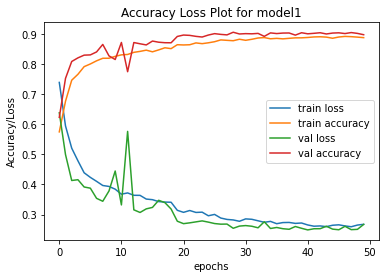

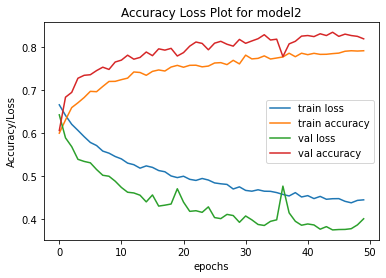

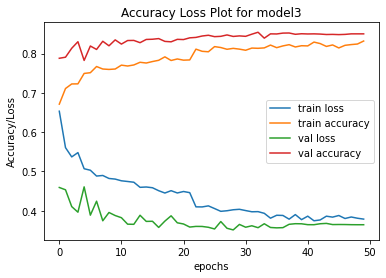

In [16]:
plt.plot(list(history1.history.values())[0])
plt.plot(list(history1.history.values())[1])
plt.plot(list(history1.history.values())[3])
plt.plot(list(history1.history.values())[4])
plt.title('Accuracy Loss Plot for model1')
plt.ylabel('Accuracy/Loss')
plt.xlabel('epochs')
plt.legend(['train loss', 'train accuracy', 'val loss', 'val accuracy'])
plt.show()

plt.plot(list(history2.history.values())[0])
plt.plot(list(history2.history.values())[1])
plt.plot(list(history2.history.values())[3])
plt.plot(list(history2.history.values())[4])
plt.title('Accuracy Loss Plot for model2')
plt.ylabel('Accuracy/Loss')
plt.xlabel('epochs')
plt.legend(['train loss', 'train accuracy', 'val loss', 'val accuracy'])
plt.show()

plt.plot(list(history3.history.values())[0])
plt.plot(list(history3.history.values())[1])
plt.plot(list(history3.history.values())[3])
plt.plot(list(history3.history.values())[4])
plt.title('Accuracy Loss Plot for model3')
plt.ylabel('Accuracy/Loss')
plt.xlabel('epochs')
plt.legend(['train loss', 'train accuracy', 'val loss', 'val accuracy'])
plt.show()

> **Task8: Compare these models on metrics like Total number of parameters, Number of trainable parameters,Training Accuracy, average F1 score, etc.**

`model name`|`total parameters`|`trainable parameters`|`train loss`|`train accuracy` | `train f1 score` | `val loss` | `val accuracy` | `val f1 score`
----|----|----|----|----|----|----|----|----
`model1` | `115,166` | `114,718` | `0.2784` | `0.8812` | `0.8812` | `0.2488` | `0.9045` | `0.9047`
`model2` | `13,982` | `13,758` | `0.4441` | `0.7892` | `0.7892` | `0.4009` | `0.8194` | `0.8194`
`model3` | `16,827,038` | `2,112,350` | `0.4498` | `0.7838` | `0.7838` | `0.3663` | `0.8355` | `0.8351`


model1 result on validation dataset
              precision    recall  f1-score   support

           0       0.59      0.56      0.57      2193
           1       0.38      0.41      0.40      1461

    accuracy                           0.50      3654
   macro avg       0.49      0.49      0.49      3654
weighted avg       0.51      0.50      0.50      3654

model2 result on validation dataset
              precision    recall  f1-score   support

           0       0.60      0.53      0.56      2193
           1       0.40      0.48      0.43      1461

    accuracy                           0.51      3654
   macro avg       0.50      0.50      0.50      3654
weighted avg       0.52      0.51      0.51      3654

model3 result on validation dataset
              precision    recall  f1-score   support

           0       0.60      0.57      0.58      2193
           1       0.40      0.42      0.41      1461

    accuracy                           0.51      3654
   macro avg       0

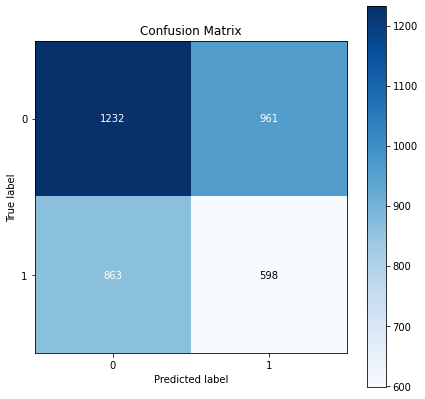

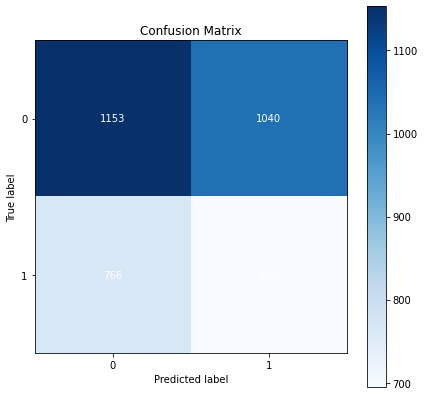

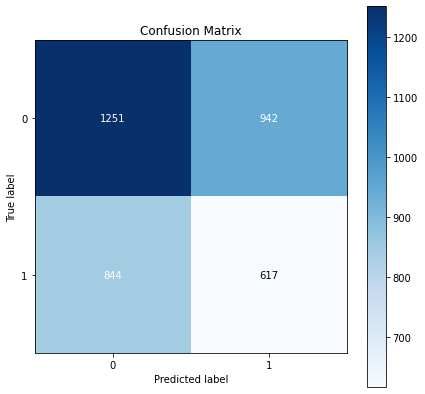

In [85]:
y = np.argmax(Val_y, axis=1)

print('model1 result on validation dataset')
Val_yhat1 = model1.predict(rescale_aug_datagen.flow(Val_X))
yhat1 = np.argmax(Val_yhat, axis=1)

# confusion matrix
plot_confusion_matrix(y, yhat1, figsize=(7,7))

# clssification report
print(classification_report(y, yhat1))

print('model2 result on validation dataset')
Val_yhat2 = model2.predict(rescale_aug_datagen.flow(Val_X))
yhat2 = np.argmax(Val_yhat2, axis=1)

# confusion matrix
plot_confusion_matrix(y, yhat2, figsize=(7,7))

# clssification report
print(classification_report(y, yhat2))

print('model3 result on validation dataset')
Val_yhat3 = model3.predict(rescale_aug_datagen.flow(Val_X))
yhat3 = np.argmax(Val_yhat3, axis=1)

# confusion matrix
plot_confusion_matrix(y, yhat3, figsize=(7,7))

# clssification report
print(classification_report(y, yhat3))

> **Task9: Test your model on the test dataset. Submit a csv file with ‘Image_index’ and ‘Pred_labels’ as the two columns.  ‘Image_index’ is nothing but the index of the image in the test data array. ‘Pred_labels’ will be either 0 (for ‘happy’) or 1 (for ‘neutral’).**

In [86]:
# making predictions on test dataset

pred = np.argmax(model1.predict(Test_X/255.), axis=1)
Predictions = pd.DataFrame()
Predictions['Pred_labels'] = pred
Predictions.index.names = ['Image_index']

Predictions.to_csv('Predictions.csv')
Predictions.head()

,Pred_labels
Image_index,
0,0
1,1
2,1
3,0
4,0


- best model is `model1` because it is light weight and performed better on train and validation data
- transfer learning model does not seem to be suitable to the current problem statement or dataset.
- current dataset 

> **Task10: Models will be evaluated on the labels generated for the test dataset**

In [56]:
# classifications on the test dataset
happy = 0
neutral = 0
for p in pred:
  if p==0:
    happy+=1
  if p==1:
    neutral+=1
print('happy classification: ', happy)
print('neutral classification: ', neutral)

happy classification:  92
neutral classification:  108


> **Task11: {Bonus} Inclusion of GradCAM interpretability atleast for 10 images (5 for each class), will attract a bonus mark.**

In [79]:
# helper functions for gradcam interpretation

def model_modifier(m):
  m.layers[-1].activation = tf.keras.activations.linear
  return m

def get_grad_model(model, layername):
  intermediate_layer_op = model.get_layer(layername).output
  model = tf.keras.models.Model(inputs=model.inputs, outputs=intermediate_layer_op)
  return model

def loss(output):
    # 1 is the imagenet index corresponding to Goldfish, 294 to Bear and 413 to Assault Rifle.
    class_id = np.argmax(output[0],-1)
    return (output[0][class_id])

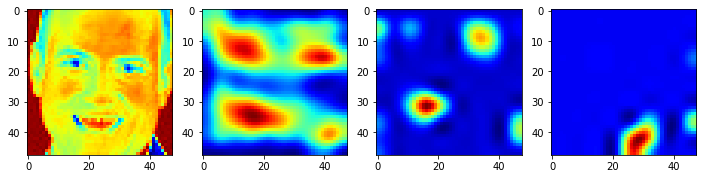

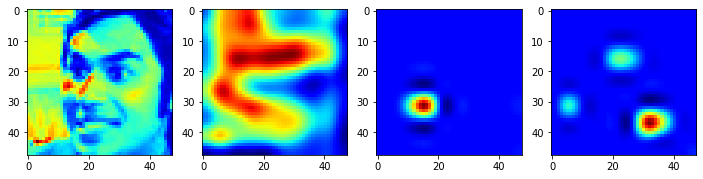

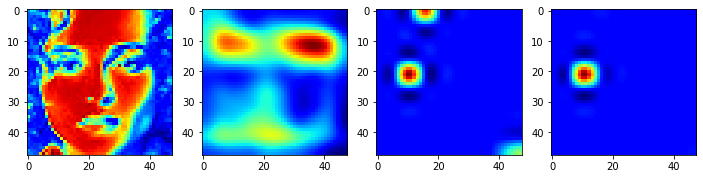

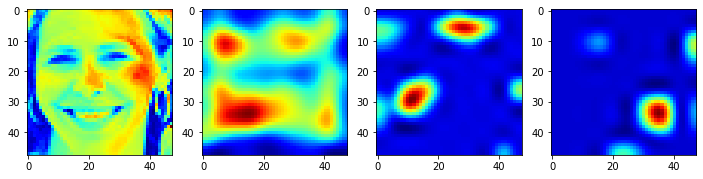

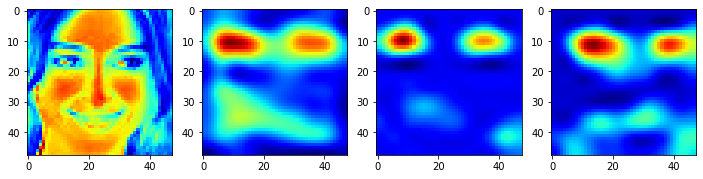

In [89]:
# happy class GradCAM interpretability

happy_image_ids = [2303, 2064, 8499, 3917, 132] # handpicked images from happy class

# Create Gradcam object
gradcam = Gradcam(model1, model_modifier=model_modifier, clone=False)
gradcam1 = Gradcam(get_grad_model(model1, 'dense1'), model_modifier=model_modifier, clone=False)
gradcam2 = Gradcam(get_grad_model(model1, 'dense2'), model_modifier=model_modifier, clone=False)

for id in happy_image_ids:
  fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(12, 12))
  # fig.tight_layout()

  img_batch = np.expand_dims(Train_X[id], axis=0)
  cam = gradcam(loss, img_batch)
  cam = normalize(cam)

  cam1 = gradcam1(loss, img_batch)
  cam1 = normalize(cam1)

  cam2 = gradcam2(loss, img_batch)
  cam2 = normalize(cam2)

  # show image
  train_img = tf.keras.preprocessing.image.array_to_img(Train_X[id])
  axes[0].imshow(train_img, cmap='jet')

  # show gradcam1
  axes[1].imshow(cam1[0], cmap='jet')

  # show gradcam2
  axes[2].imshow(cam2[0], cmap='jet')

  # show gradcam
  axes[3].imshow(cam[0], cmap='jet')

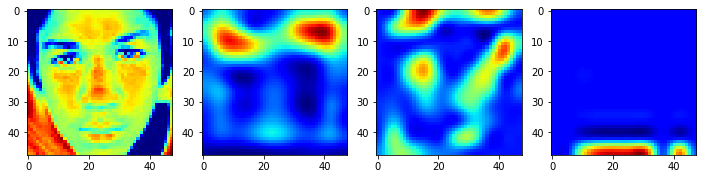

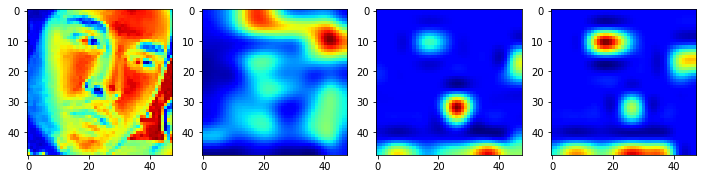

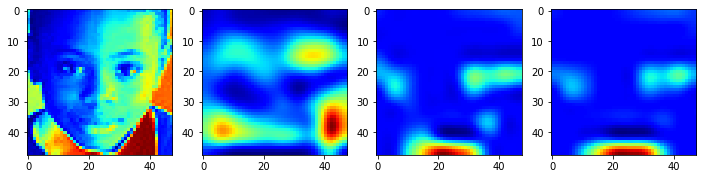

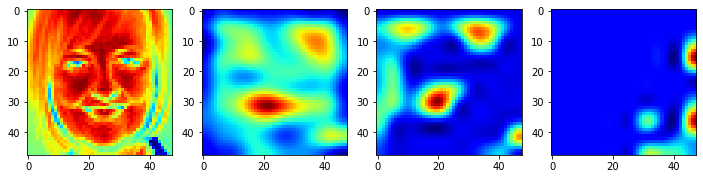

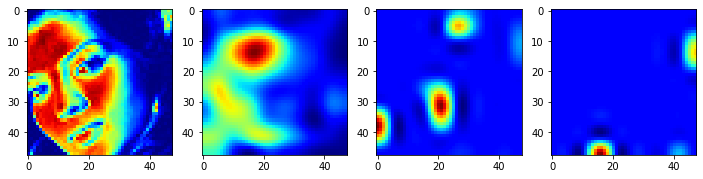

In [90]:
# happy class GradCAM interpretability

neutral_image_ids = [5585, 2947, 706, 4810, 8508] # handpicked images from neutral class

# Create Gradcam object
gradcam = Gradcam(model1, model_modifier=model_modifier, clone=False)
gradcam1 = Gradcam(get_grad_model(model1, 'dense1'), model_modifier=model_modifier, clone=False)
gradcam2 = Gradcam(get_grad_model(model1, 'dense2'), model_modifier=model_modifier, clone=False)

for id in neutral_image_ids:
  fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(12, 12))
  # fig.tight_layout()

  img_batch = np.expand_dims(Train_X[id], axis=0)
  cam = gradcam(loss, img_batch)
  cam = normalize(cam)

  cam1 = gradcam1(loss, img_batch)
  cam1 = normalize(cam1)

  cam2 = gradcam2(loss, img_batch)
  cam2 = normalize(cam2)

  # show image
  train_img = tf.keras.preprocessing.image.array_to_img(Train_X[id])
  axes[0].imshow(train_img, cmap='jet')

  # show gradcam1
  axes[1].imshow(cam1[0], cmap='jet')

  # show gradcam2
  axes[2].imshow(cam2[0], cmap='jet')

  # show gradcam
  axes[3].imshow(cam[0], cmap='jet')

- the model is gradually learning to concentrate on eyes and mouth to classify facial emotions
- layer by layer the concentration is more focused on eyes and mouth